In [36]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

## Visualize the datasets

Plot the dust deposition rate of the empirical dataset in the measurement locations and the simulated data on the global grid.

In [37]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [38]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [39]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


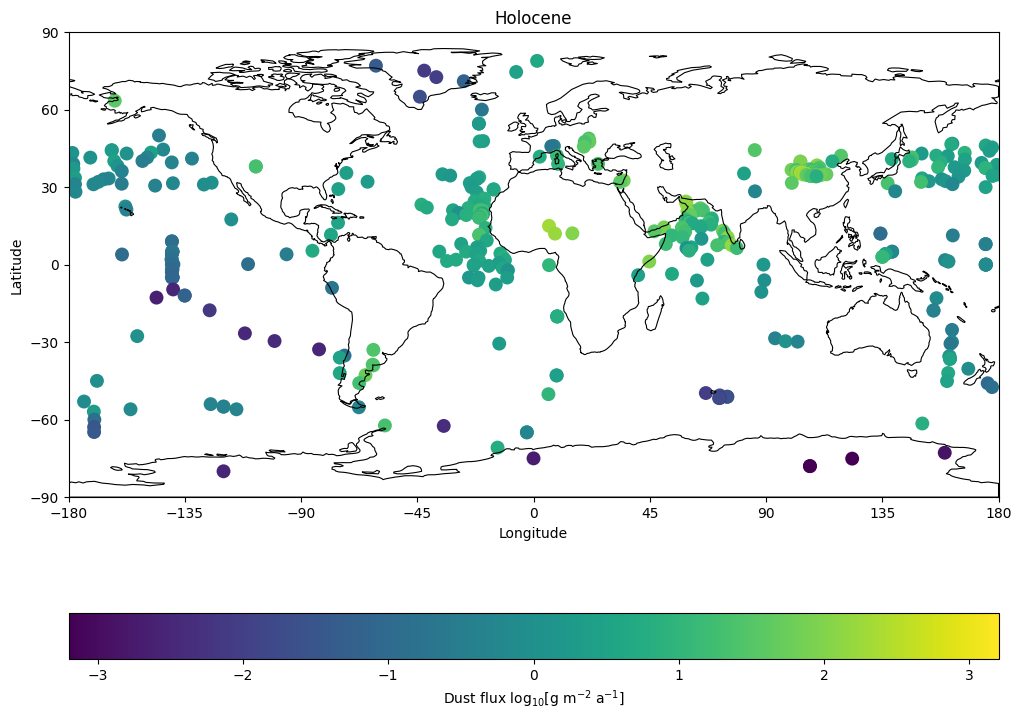

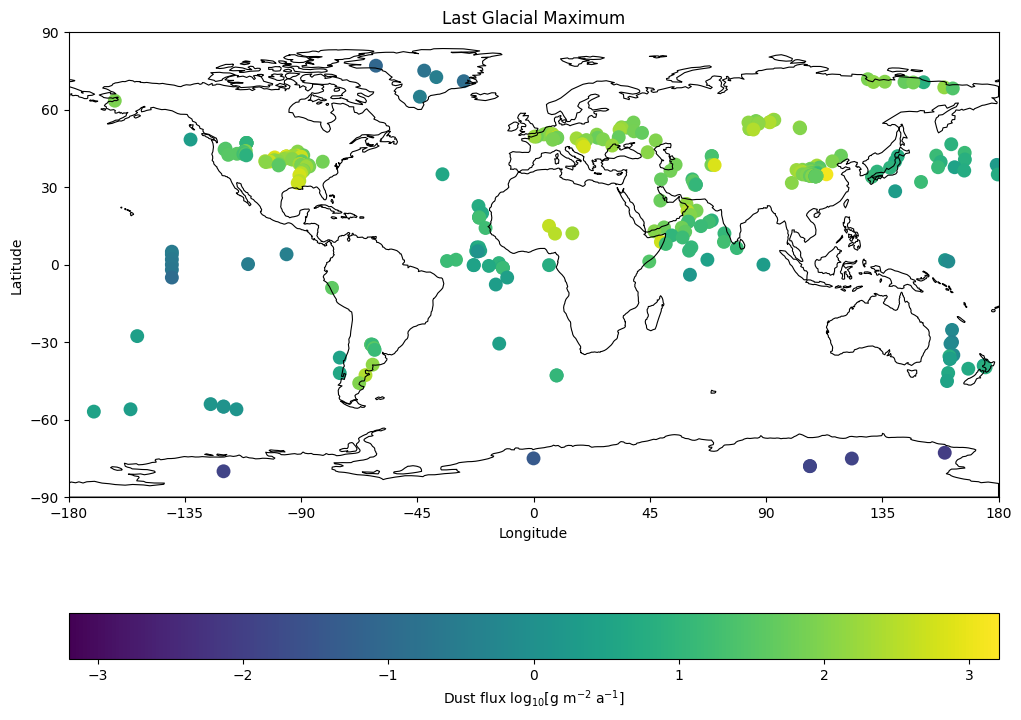

In [40]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Create and visualize the global grid

The global grid for the predictions consists of 3-degree spacing.

In [41]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

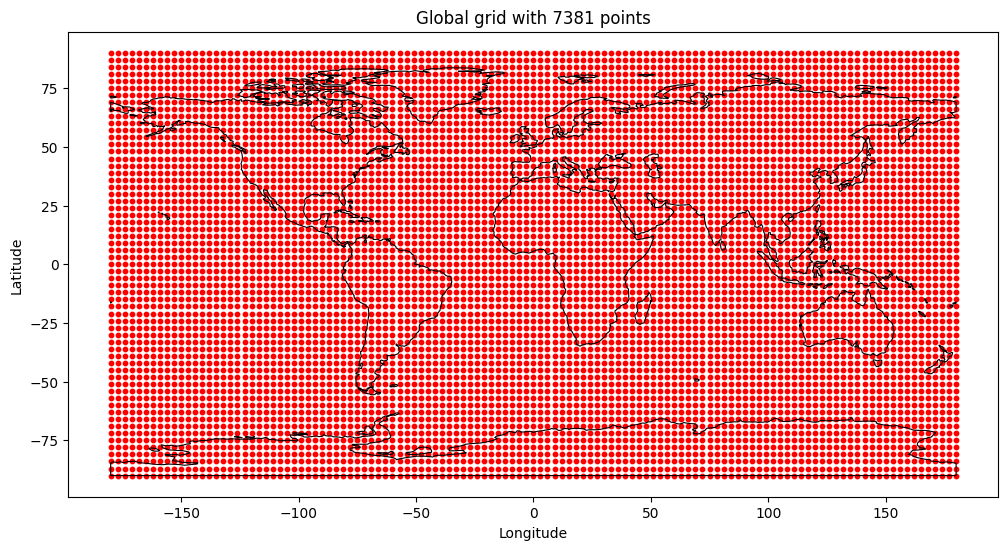

In [42]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [43]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

In [44]:
def distance_geodesic(x, y):
    """
    Calculate the geodesic distance between two points on Earth.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    phi1, lambda1 = np.radians(x)
    phi2, lambda2 = np.radians(y)
    R = 6371
    #distancia geodesica
    distancia = R * np.arccos(np.sin(phi1)*np.sin(phi2) + np.cos(phi1)*np.cos(phi2)*np.cos(lambda1 - lambda2))

    return distancia

In [45]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """
    
    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean
    
    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))
    
    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]
    
    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)
    
    return estimation

In [95]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 2

In [96]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm

geodesic = df_global_grid.copy()

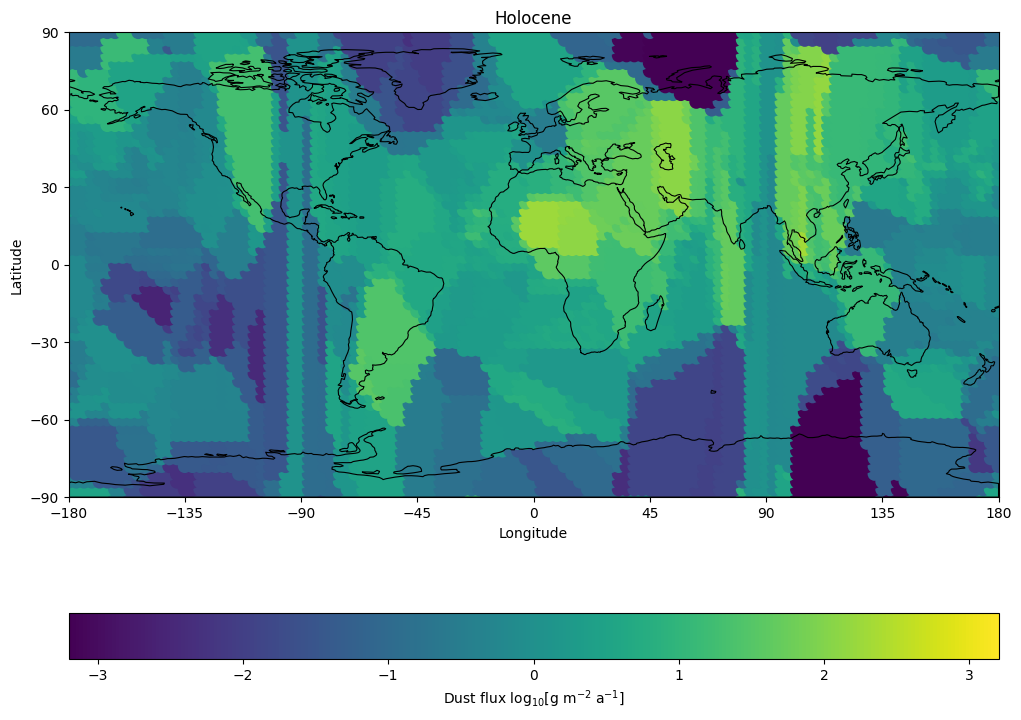

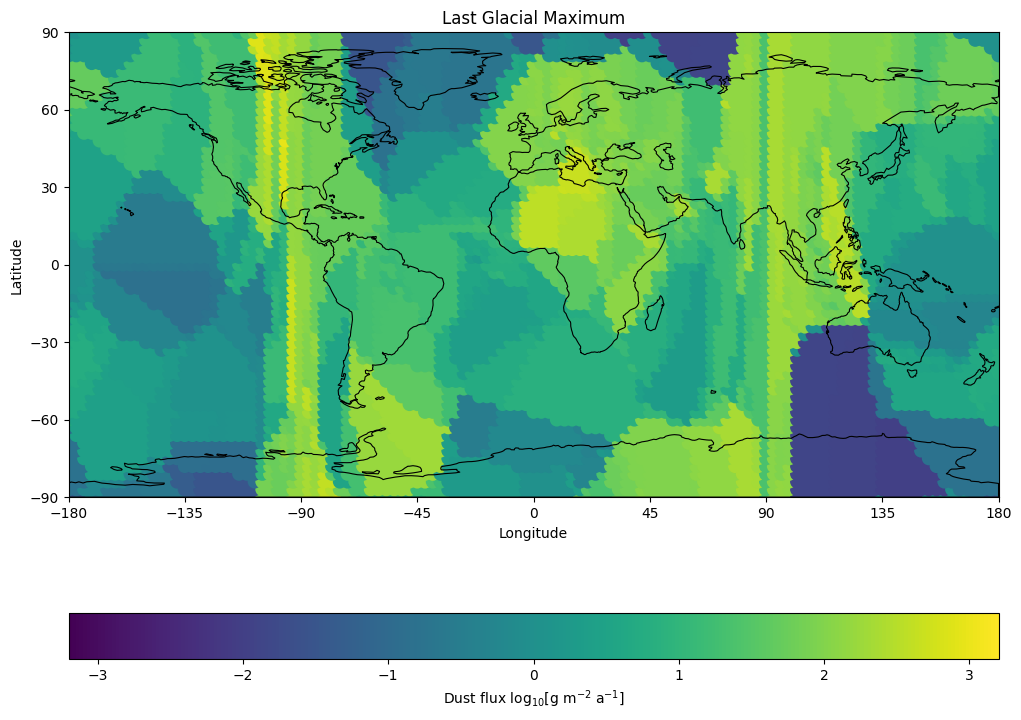

In [97]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid, 
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

In [49]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm


euclidean = df_global_grid.copy()

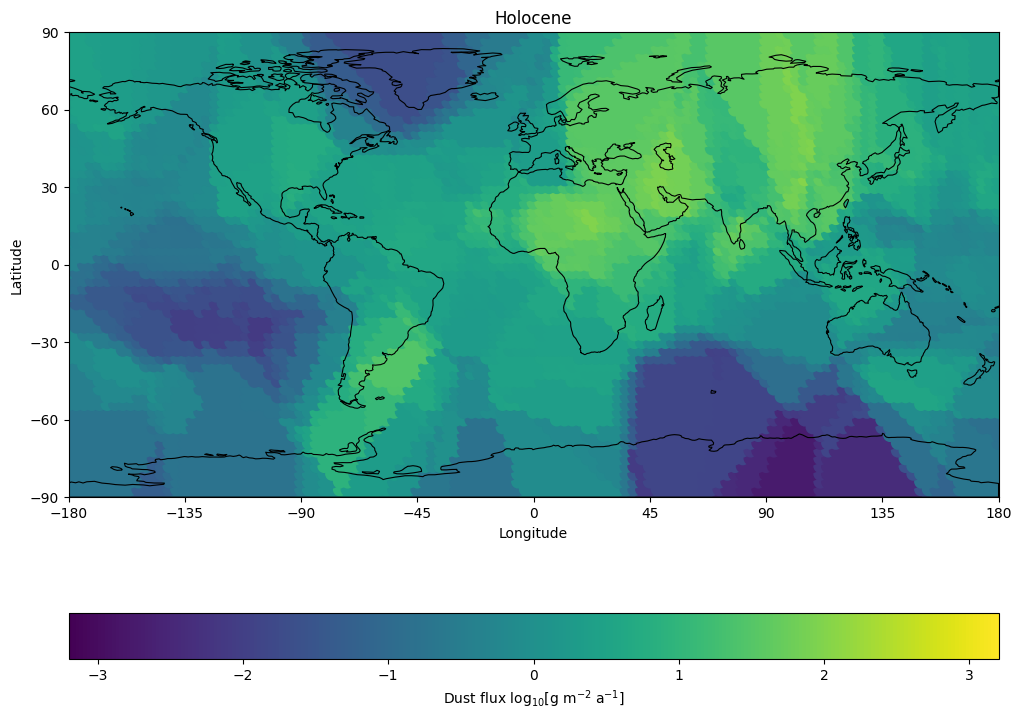

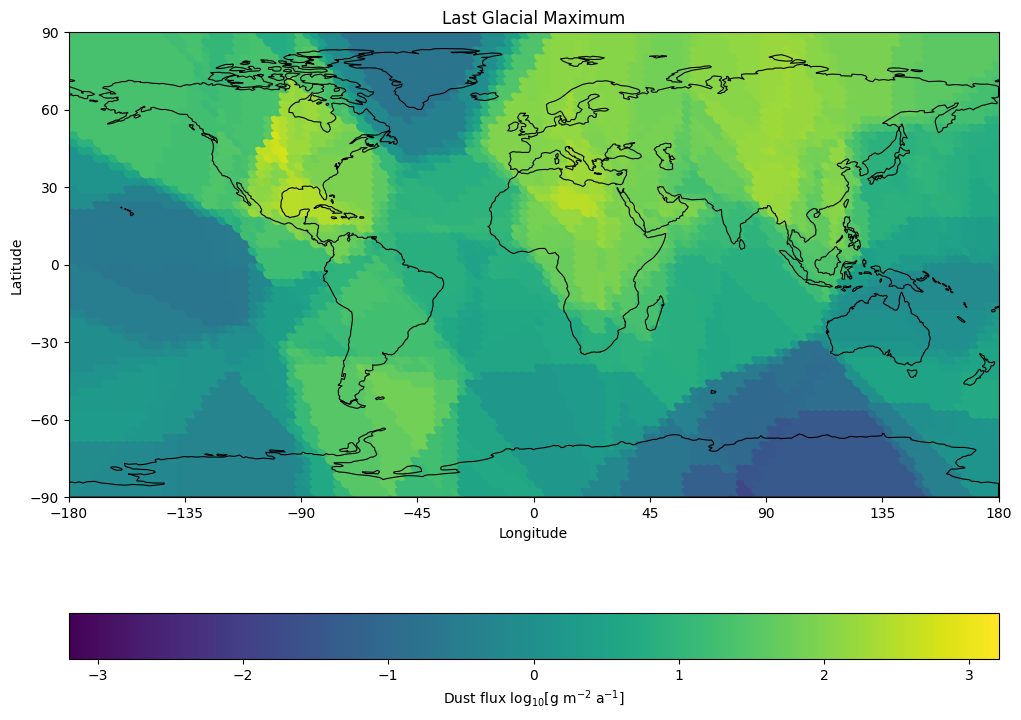

In [50]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

In [51]:
print(geodesic, euclidean)

        lon   lat   est_hol   est_lgm
0    -180.0 -90.0 -0.943857  0.336214
1    -177.0 -90.0 -0.943857 -0.531728
2    -174.0 -90.0 -0.611015 -0.531728
3    -171.0 -90.0 -0.611015 -0.531728
4    -168.0 -90.0 -0.611015 -0.271522
...     ...   ...       ...       ...
7376  168.0  90.0 -0.000511  0.965428
7377  171.0  90.0 -0.000511  0.965428
7378  174.0  90.0 -0.000511  0.965428
7379  177.0  90.0 -0.000511  0.988117
7380  180.0  90.0 -0.000511  0.988117

[7381 rows x 4 columns]         lon   lat   est_hol   est_lgm
0    -180.0 -90.0 -0.736623 -0.111441
1    -177.0 -90.0 -0.736623 -0.111441
2    -174.0 -90.0 -0.736623 -0.175193
3    -171.0 -90.0 -0.736623 -0.175193
4    -168.0 -90.0 -0.740268 -0.175193
...     ...   ...       ...       ...
7376  168.0  90.0  0.388114  1.583464
7377  171.0  90.0  0.388114  1.583464
7378  174.0  90.0  0.388114  1.583464
7379  177.0  90.0  0.388114  1.583464
7380  180.0  90.0  0.388114  1.583464

[7381 rows x 4 columns]


In [77]:
df_geodesic = pd.DataFrame(geodesic, columns=['lon', 'lat', 'est_hol', 'est_lgm'])

df_euclidean = pd.DataFrame(euclidean, columns=['lon', 'lat', 'est_hol', 'est_lgm'])


In [87]:
df_geodesic

,lon,lat,est_hol,est_lgm,diferencia_est_hol,diferencia_est_lgm
0,-180.0,-90.0,-0.943857,0.336214,0.207234,0.447655
1,-177.0,-90.0,-0.943857,-0.531728,0.207234,0.420286
2,-174.0,-90.0,-0.611015,-0.531728,0.125608,0.356535
3,-171.0,-90.0,-0.611015,-0.531728,0.125608,0.356535
4,-168.0,-90.0,-0.611015,-0.271522,0.129252,0.096329
...,...,...,...,...,...,...
7376,168.0,90.0,-0.000511,0.965428,0.388625,0.618035
7377,171.0,90.0,-0.000511,0.965428,0.388625,0.618035
7378,174.0,90.0,-0.000511,0.965428,0.388625,0.618035
7379,177.0,90.0,-0.000511,0.988117,0.388625,0.595347


In [88]:
df_euclidean

,lon,lat,est_hol,est_lgm
0,-180.0,-90.0,-0.736623,-0.111441
1,-177.0,-90.0,-0.736623,-0.111441
2,-174.0,-90.0,-0.736623,-0.175193
3,-171.0,-90.0,-0.736623,-0.175193
4,-168.0,-90.0,-0.740268,-0.175193
...,...,...,...,...
7376,168.0,90.0,0.388114,1.583464
7377,171.0,90.0,0.388114,1.583464
7378,174.0,90.0,0.388114,1.583464
7379,177.0,90.0,0.388114,1.583464


In [74]:
# Saco el promedio de est_hol para euclidean y geodesic
promedio_est_hol_euclidean = df_euclidean['est_hol'].mean()
promedio_est_hol_geodesic = df_geodesic['est_hol'].mean()

promedio_est_lgm_euclidean = df_euclidean['est_lgm'].mean()
promedio_est_lgm_geodesic = df_geodesic['est_lgm'].mean()

# las imprimo
print(f'Promedio de est_hol para euclidean y geodesic respectivamente {promedio_est_hol_euclidean} y {promedio_est_hol_geodesic}')
print(f'Promedio de est_lgm para euclidean y geodesic respectivamente {promedio_est_lgm_euclidean} y {promedio_est_lgm_geodesic}')



Promedio de est_hol para euclidean y geodesic respectivamente 0.014574502950696844 y -0.04281792645246572
Promedio de est_lgm para euclidean y geodesic respectivamente 0.7363995758475036 y 0.9999865852430466


In [86]:
# Ahora calcularemos la diferencia entre los valores de est_hol y est_lgm para euclidean y geodesic para caada punto, diferencia en valor absoluto
df_geodesic['diferencia_est_hol'] = abs(df_geodesic['est_hol'] - df_euclidean['est_hol'])
df_geodesic['diferencia_est_lgm'] = abs(df_geodesic['est_lgm'] - df_euclidean['est_lgm'])

df_geodesic

,lon,lat,est_hol,est_lgm,diferencia_est_hol,diferencia_est_lgm
0,-180.0,-90.0,-0.943857,0.336214,0.207234,0.447655
1,-177.0,-90.0,-0.943857,-0.531728,0.207234,0.420286
2,-174.0,-90.0,-0.611015,-0.531728,0.125608,0.356535
3,-171.0,-90.0,-0.611015,-0.531728,0.125608,0.356535
4,-168.0,-90.0,-0.611015,-0.271522,0.129252,0.096329
...,...,...,...,...,...,...
7376,168.0,90.0,-0.000511,0.965428,0.388625,0.618035
7377,171.0,90.0,-0.000511,0.965428,0.388625,0.618035
7378,174.0,90.0,-0.000511,0.965428,0.388625,0.618035
7379,177.0,90.0,-0.000511,0.988117,0.388625,0.595347


En este df_geodesic podemos notar las diferencias entre est_hol y est_lgm con las columnas diferencia_est_hol y diferencia_est_lgm las cuales representan la diferencia en valor absoluto entre las distancia euclideana y geodesica.

6.
a) Esto se debe a que por ejemplo en los polos la curvatura de la tierra es mucho mas pronunciada, por lo tanto, si usamos la distancia euclideana, no estariamos tomando en cuenta esta curvatura mucho mas pronunciada, en cambio al usar la distancia geodesica y usar la forma real de la tierra (El radio de esta) esta es mucho mas fidedigna y hay mayores concentraciones en ciertos lugares, ya que no toma que estamos sacando distancias en un espacio plano.

b) El metodo mas fidedigno den los polos sur y norte es la estimacion usando la distancia geodesica, ya que tomamos en cuenta la forma real de la Tierra, y debido a que la curvatura de la tierra es mas pronunciada en los polos es muchisimo mas fidedigno ocupar la estimacion con distancia geodesica.

c) Como dije anteriormente lo mas fidedigno es la estimacion con distancia geodesica para cualquier longitud.

d) La diferencia que podemos ver para los resultados del Holoceno y el LGM, es que por ejemplo En el Holoceno para la estimacion con distancia euclideana Rusia tiene un mayor flujo de polvo en cambio la estimacion con la distancia geodesica, podemos notar una menor flujo de polvo en la zona hacia el norte de Rusia que justo coincide con el polo norte y la curvatura mayor de la tierra. Por otro lado con el LGM podemos notar que cerca del continente de Oceanía, hacia la latitud de 90° existe una mayor flujo de polvo con geodesica que con euclideana, misma situacion que con el polo sur, con geodesica se nota un mayor dust flux que con la estimacion con distancia euclideana.

e) Lo que hice yo fue probando, probe con 5 con el que venia el codigo, 10 y luego 30, pude notar que al elegir 10 en comparacion con el de 5 vecinos, este se notaba mucho menos, osea que se iba por decirlo de alguna manera homogeneizando un poco el dust flux, luego al pasar para 30 vecinos casi que no se veian diferencias para nada marcadas, osea que mientras mayor los vecinos era mucho mayor el suavizado del mapa, por lo que se perdian detalles en comparacion con 5. Por lo tanto para poder considerar el dust flux, y ver de de manera mas detallada estos parametros es mejor con menos vecinos así no se suavizan de sobre manera las estimaciones ya que queremos ver con detalle el dust flux